In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/satyajeet-extracting-data-formating/__results__.html
/kaggle/input/satyajeet-extracting-data-formating/__notebook__.ipynb
/kaggle/input/satyajeet-extracting-data-formating/__output__.json
/kaggle/input/satyajeet-extracting-data-formating/custom.css
/kaggle/input/satyajeet-extracting-data-formating/train_img/colon_114.nii.gz
/kaggle/input/satyajeet-extracting-data-formating/train_img/colon_042.nii.gz
/kaggle/input/satyajeet-extracting-data-formating/train_img/colon_066.nii.gz
/kaggle/input/satyajeet-extracting-data-formating/train_img/colon_064.nii.gz
/kaggle/input/satyajeet-extracting-data-formating/train_img/colon_086.nii.gz
/kaggle/input/satyajeet-extracting-data-formating/train_img/colon_029.nii.gz
/kaggle/input/satyajeet-extracting-data-formating/train_img/colon_069.nii.gz
/kaggle/input/satyajeet-extracting-data-formating/train_img/colon_099.nii.gz
/kaggle/input/satyajeet-extracting-data-formating/train_img/colon_039.nii.gz
/kaggle/input/satyajeet-extracting-data-form

In [2]:
# neural imaging
#!pip install nilearn
import nibabel as nib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
import cv2
import glob

In [3]:
#setting volume paths
volume_train_img = "/kaggle/input/satyajeet-extracting-data-formating/train_img/"
volume_train_mask = "/kaggle/input/satyajeet-extracting-data-formating/train_mask/"

volume_valid_img = "/kaggle/input/satyajeet-extracting-data-formating/valid_img/"
volume_valid_mask = "/kaggle/input/satyajeet-extracting-data-formating/valid_mask/"

volume_test_img = "/kaggle/input/satyajeet-extracting-data-formating/test_img/"

In [4]:
#setting slice paths
slice_train_img = "train/img/img/"
os.makedirs(slice_train_img, exist_ok=True)
slice_train_mask = "train/mask/img/"
os.makedirs(slice_train_mask, exist_ok=True)

slice_valid_img = "valid/img/img/"
os.makedirs(slice_valid_img, exist_ok=True)
slice_valid_mask = "valid/mask/img/"
os.makedirs(slice_valid_mask, exist_ok=True)

slice_test_img = "test/img/img/"
os.makedirs(slice_test_img, exist_ok=True)
#slice_test_mask = "test/mask/img/"

In [5]:
"""Setting Some Parameters"""
#Setting values of HU
HU_MIN = -1000
HU_MAX = 3000

SLICE_X = False
SLICE_Y = False
SLICE_Z = True
SLICE_DECIMATE_IDENTIFIER = 3

In [6]:
img_path = os.path.join(volume_train_img, "colon_027.nii.gz")
img = nib.load(img_path).get_fdata()
print("***Image***")
print(f"minimum pixel intensity value : {np.min(img)}")
print(f"maximum pixel intensity value : {np.max(img)}")
print(f"image shape : {img.shape}")
print(f"image type : {type(img)}")

***Image***
minimum pixel intensity value : -1024.0
maximum pixel intensity value : 3071.0
image shape : (512, 512, 38)
image type : <class 'numpy.ndarray'>


In [7]:
mask_path = os.path.join(volume_train_mask, "colon_027.nii.gz")
mask = nib.load(mask_path).get_fdata()
print("***Mask***")
print(f"minimum pixel intensity value : {np.min(mask)}")
print(f"maximum pixel intensity value : {np.max(mask)}")
print(f"image shape : {mask.shape}")
print(f"image type : {type(mask)}")

***Mask***
minimum pixel intensity value : 0.0
maximum pixel intensity value : 1.0
image shape : (512, 512, 38)
image type : <class 'numpy.ndarray'>


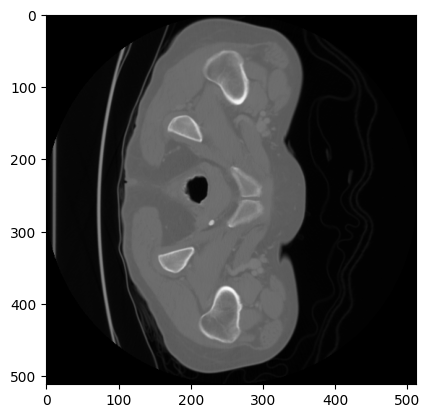

In [8]:
img_slice = img[:,:,5]
plt.imshow(img_slice,cmap = 'gray')

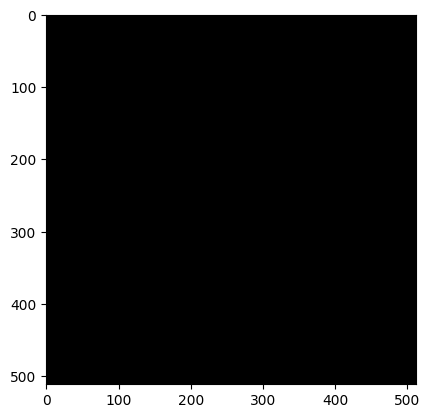

In [9]:
mask_slice = mask[:,:,5]
plt.imshow(mask_slice,cmap = 'gray')

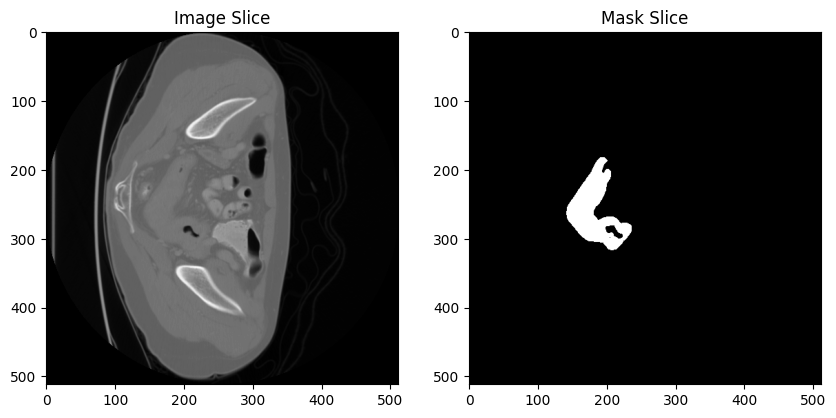

In [10]:
z= 20
img_slice = img[:,:,z]
mask_slice = mask[:,:,z]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(img_slice, cmap='gray')
ax1.set_title('Image Slice')
ax2.imshow(mask_slice, cmap='gray')
ax2.set_title('Mask Slice')
plt.show()

In [11]:
def normalize_img_intensity_range(img):
  img[img < HU_MIN] = HU_MIN
  img[img > HU_MAX] = HU_MAX
  return (img - HU_MIN) / (HU_MAX - HU_MIN)

In [12]:
norm_img = normalize_img_intensity_range(img)
print("***Image***")
print(f"minimum pixel intensity value : {np.min(norm_img)}")
print(f"maximum pixel intensity value : {np.max(norm_img)}")
print(f"image shape : {norm_img.shape}")
print(f"image type : {type(norm_img)}")

***Image***
minimum pixel intensity value : 0.0
maximum pixel intensity value : 1.0
image shape : (512, 512, 38)
image type : <class 'numpy.ndarray'>


In [13]:
def read_img_volume(img_path , normalize = False):
  img = nib.load(img_path).get_fdata()
  if normalize:
    return normalize_img_intensity_range(img)
  else:
    return img

In [14]:
def save_slice(img, fname, path):
  img = np.uint8(img * 255)
  fout = os.path.join(path, f"{fname}.png")
  cv2.imwrite(fout, img)
  print(f"[+] Slice saved : {fout}")

In [15]:
def slice_save_volume_image(vol, fname, path):
    (dimx, dimy, dimz) = vol.shape
    print(dimx, dimy, dimz)
    cnt = 0
    if SLICE_X:
        cnt += dimx
        print('Slicing X: ')
        for i in range(dimx):
            save_slice(vol[i,:,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_x', path)

    if SLICE_Y:
        cnt += dimy
        print('Slicing Y: ')
        for i in range(dimy):
            save_slice(vol[:,i,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_y', path)

    if SLICE_Z:
        cnt += dimz
        print('Slicing Z: ')
        for i in range(dimz):
            save_slice(vol[:,:,i], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_z', path)
    return cnt

In [16]:
# Read and process image volumes
# Volume train img ---> Slice train img
total_slices = 0
for index, filename in enumerate(sorted(glob.iglob(volume_train_img+'*.nii.gz'))):
    img = read_img_volume(filename,normalize = True)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = slice_save_volume_image(img, 'colon'+str(index), slice_train_img)
    total_slices += numOfSlices
    print(f'\n{filename}, {numOfSlices} slices created \n')
print(f"Total slices created and saved : {total_slices}")

/kaggle/input/satyajeet-extracting-data-formating/train_img/colon_001.nii.gz (512, 512, 60) 1084 0.0 1.0
512 512 60
Slicing Z: 
[+] Slice saved : train/img/img/colon0-slice000_z.png
[+] Slice saved : train/img/img/colon0-slice001_z.png
[+] Slice saved : train/img/img/colon0-slice002_z.png
[+] Slice saved : train/img/img/colon0-slice003_z.png
[+] Slice saved : train/img/img/colon0-slice004_z.png
[+] Slice saved : train/img/img/colon0-slice005_z.png
[+] Slice saved : train/img/img/colon0-slice006_z.png
[+] Slice saved : train/img/img/colon0-slice007_z.png
[+] Slice saved : train/img/img/colon0-slice008_z.png
[+] Slice saved : train/img/img/colon0-slice009_z.png
[+] Slice saved : train/img/img/colon0-slice010_z.png
[+] Slice saved : train/img/img/colon0-slice011_z.png
[+] Slice saved : train/img/img/colon0-slice012_z.png
[+] Slice saved : train/img/img/colon0-slice013_z.png
[+] Slice saved : train/img/img/colon0-slice014_z.png
[+] Slice saved : train/img/img/colon0-slice015_z.png
[+] Slic

In [17]:
# Read and process image volumes
# Volume train mask ---> Slice train mask
total_slices = 0
for index, filename in enumerate(sorted(glob.iglob(volume_train_mask+'*.nii.gz'))):
    img = read_img_volume(filename,normalize = False)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = slice_save_volume_image(img, 'colon'+str(index), slice_train_mask)
    total_slices += numOfSlices
    print(f'\n{filename}, {numOfSlices} slices created \n')
print(f"Total slices created and saved : {total_slices}")

/kaggle/input/satyajeet-extracting-data-formating/train_mask/colon_001.nii.gz (512, 512, 60) 1084 0.0 1.0
512 512 60
Slicing Z: 
[+] Slice saved : train/mask/img/colon0-slice000_z.png
[+] Slice saved : train/mask/img/colon0-slice001_z.png
[+] Slice saved : train/mask/img/colon0-slice002_z.png
[+] Slice saved : train/mask/img/colon0-slice003_z.png
[+] Slice saved : train/mask/img/colon0-slice004_z.png
[+] Slice saved : train/mask/img/colon0-slice005_z.png
[+] Slice saved : train/mask/img/colon0-slice006_z.png
[+] Slice saved : train/mask/img/colon0-slice007_z.png
[+] Slice saved : train/mask/img/colon0-slice008_z.png
[+] Slice saved : train/mask/img/colon0-slice009_z.png
[+] Slice saved : train/mask/img/colon0-slice010_z.png
[+] Slice saved : train/mask/img/colon0-slice011_z.png
[+] Slice saved : train/mask/img/colon0-slice012_z.png
[+] Slice saved : train/mask/img/colon0-slice013_z.png
[+] Slice saved : train/mask/img/colon0-slice014_z.png
[+] Slice saved : train/mask/img/colon0-slice0

In [18]:
# Read and process image volumes
# Volume validation img ---> Slice Validation img
total_slices = 0
for index, filename in enumerate(sorted(glob.iglob(volume_valid_img+'*.nii.gz'))):
    img = read_img_volume(filename,normalize = True)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = slice_save_volume_image(img, 'colon'+str(index), slice_valid_img)
    total_slices += numOfSlices
    print(f'\n{filename}, {numOfSlices} slices created \n')
print(f"Total slices created and saved : {total_slices}")

/kaggle/input/satyajeet-extracting-data-formating/valid_img/colon_171.nii.gz (512, 512, 119) 1143 0.0 1.0
512 512 119
Slicing Z: 
[+] Slice saved : valid/img/img/colon0-slice000_z.png
[+] Slice saved : valid/img/img/colon0-slice001_z.png
[+] Slice saved : valid/img/img/colon0-slice002_z.png
[+] Slice saved : valid/img/img/colon0-slice003_z.png
[+] Slice saved : valid/img/img/colon0-slice004_z.png
[+] Slice saved : valid/img/img/colon0-slice005_z.png
[+] Slice saved : valid/img/img/colon0-slice006_z.png
[+] Slice saved : valid/img/img/colon0-slice007_z.png
[+] Slice saved : valid/img/img/colon0-slice008_z.png
[+] Slice saved : valid/img/img/colon0-slice009_z.png
[+] Slice saved : valid/img/img/colon0-slice010_z.png
[+] Slice saved : valid/img/img/colon0-slice011_z.png
[+] Slice saved : valid/img/img/colon0-slice012_z.png
[+] Slice saved : valid/img/img/colon0-slice013_z.png
[+] Slice saved : valid/img/img/colon0-slice014_z.png
[+] Slice saved : valid/img/img/colon0-slice015_z.png
[+] Sl

In [19]:
# Read and process mask volumes
# Volume validation masks ---> Slice Validation masks
total_slices = 0
for index, filename in enumerate(sorted(glob.iglob(volume_valid_mask+'*.nii.gz'))):
    mask = read_img_volume(filename,normalize = False)
    print(filename, mask.shape, np.sum(mask.shape), np.min(mask), np.max(mask))
    numOfSlices = slice_save_volume_image(mask, 'colon'+str(index), slice_valid_mask)
    total_slices += numOfSlices
    print(f'\n{filename}, {numOfSlices} slices created \n')
print(f"Total slices created and saved : {total_slices}")

/kaggle/input/satyajeet-extracting-data-formating/valid_mask/colon_171.nii.gz (512, 512, 119) 1143 0.0 1.0
512 512 119
Slicing Z: 
[+] Slice saved : valid/mask/img/colon0-slice000_z.png
[+] Slice saved : valid/mask/img/colon0-slice001_z.png
[+] Slice saved : valid/mask/img/colon0-slice002_z.png
[+] Slice saved : valid/mask/img/colon0-slice003_z.png
[+] Slice saved : valid/mask/img/colon0-slice004_z.png
[+] Slice saved : valid/mask/img/colon0-slice005_z.png
[+] Slice saved : valid/mask/img/colon0-slice006_z.png
[+] Slice saved : valid/mask/img/colon0-slice007_z.png
[+] Slice saved : valid/mask/img/colon0-slice008_z.png
[+] Slice saved : valid/mask/img/colon0-slice009_z.png
[+] Slice saved : valid/mask/img/colon0-slice010_z.png
[+] Slice saved : valid/mask/img/colon0-slice011_z.png
[+] Slice saved : valid/mask/img/colon0-slice012_z.png
[+] Slice saved : valid/mask/img/colon0-slice013_z.png
[+] Slice saved : valid/mask/img/colon0-slice014_z.png
[+] Slice saved : valid/mask/img/colon0-slic

In [20]:
# Read and process image volumes
# Volume test img ---> Slice test img
total_slices = 0
for index, filename in enumerate(sorted(glob.iglob(volume_test_img+'*.nii.gz'))):
    img = read_img_volume(filename,normalize = True)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = slice_save_volume_image(img, 'colon'+str(index), slice_test_img)
    total_slices += numOfSlices
    print(f'\n{filename}, {numOfSlices} slices created \n')
print(f"Total slices created and saved : {total_slices}")

/kaggle/input/satyajeet-extracting-data-formating/test_img/colon_003.nii.gz (512, 512, 127) 1151 0.0 1.0
512 512 127
Slicing Z: 
[+] Slice saved : test/img/img/colon0-slice000_z.png
[+] Slice saved : test/img/img/colon0-slice001_z.png
[+] Slice saved : test/img/img/colon0-slice002_z.png
[+] Slice saved : test/img/img/colon0-slice003_z.png
[+] Slice saved : test/img/img/colon0-slice004_z.png
[+] Slice saved : test/img/img/colon0-slice005_z.png
[+] Slice saved : test/img/img/colon0-slice006_z.png
[+] Slice saved : test/img/img/colon0-slice007_z.png
[+] Slice saved : test/img/img/colon0-slice008_z.png
[+] Slice saved : test/img/img/colon0-slice009_z.png
[+] Slice saved : test/img/img/colon0-slice010_z.png
[+] Slice saved : test/img/img/colon0-slice011_z.png
[+] Slice saved : test/img/img/colon0-slice012_z.png
[+] Slice saved : test/img/img/colon0-slice013_z.png
[+] Slice saved : test/img/img/colon0-slice014_z.png
[+] Slice saved : test/img/img/colon0-slice015_z.png
[+] Slice saved : test/